In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
# set the matplotlib backend so figures can be saved in the background
from tqdm.notebook import tqdm
import matplotlib
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers.convolutional.conv2d import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow
from tensorflow import keras
import time

2023-01-11 18:04:26.209566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 18:04:26.297532: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-11 18:04:26.318998: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-11 18:04:26.782071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
def conv_module(input,No_of_filters,filtersizeX,filtersizeY,stride,chanDim,padding="same"):
    input = Conv2D(No_of_filters,(filtersizeX,filtersizeY),strides=stride,padding=padding)(input)
    input = BatchNormalization(axis=chanDim)(input)
    input = Activation("relu")(input)
    return input

def inception_module(input,numK1x1,numK3x3,numk5x5,numPoolProj,chanDim):
                                 #Step 1
    conv_1x1 = conv_module(input, numK1x1, 1, 1,(1, 1), chanDim) 
                                 #Step 2
    conv_3x3 = conv_module(input, numK3x3, 3, 3,(1, 1), chanDim)
    conv_5x5 = conv_module(input, numk5x5, 5, 5,(1, 1), chanDim)
                                 #Step 3
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
                                 #Step 4
    input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
    return input

def downsample_module(input,No_of_filters,chanDim):
    conv_3x3=conv_module(input,No_of_filters,3,3,(2,2),chanDim,padding="valid")
    pool = MaxPooling2D((3,3),strides=(2,2))(input)
    input = concatenate([conv_3x3,pool],axis=chanDim)
    return input

In [4]:
def MiniGoogleNet(width,height,depth,classes):
    inputShape=(height,width,depth)
    chanDim=-1

    # (Step 1) Define the model input
    inputs = Input(shape=inputShape)

    # First CONV module
    x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)

    # (Step 2) Two Inception modules followed by a downsample module
    x = inception_module(x, 32, 32,32,32,chanDim)
    x = inception_module(x, 32, 48, 48,32,chanDim)
    x = downsample_module(x, 80, chanDim)

    # (Step 3) Five Inception modules followed by a downsample module
    x = inception_module(x, 112, 48, 32, 48,chanDim)
    x = inception_module(x, 96, 64, 32,32,chanDim)
    x = inception_module(x, 80, 80, 32,32,chanDim)
    x = inception_module(x, 48, 96, 32,32,chanDim)
    x = inception_module(x, 112, 48, 32, 48,chanDim)
    x = downsample_module(x, 96, chanDim)

    # (Step 4) Two Inception modules followed
    x = inception_module(x, 176, 160,96,96, chanDim)
    x = inception_module(x, 176, 160, 96,96,chanDim)

    # Global POOL and dropout
    x = AveragePooling2D((7, 7))(x)
    x = Dropout(0.5)(x)

    # (Step 5) Softmax classifier
    x = Flatten()(x)
    x = Dense(classes)(x)
    x = Activation("softmax")(x)

    # Create the model
    model = Model(inputs, x, name="googlenet")
    return model

In [5]:
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")


[INFO] loading Fashion MNIST data...


#### 1. Fix batch size to 64 and start with 10 candidate learning rates between 10^−9 and 10 and train your model for 5 epochs. Plot the training loss as a function of the learning rate. You should see a curve like Figure 3 in the reference below. From that figure identify the values of lrmin and lrmax.

#### 2. Use the cyclical learning rate policy (with exponential decay) and train your network using batch size 64 and lrmin and lrmax values obtained in part 1. Plot train/validation loss and accuracy curve (similar to Figure 4 in reference). 

In [6]:
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "exp_range"
NUM_EPOCHS = 16

In [7]:
train_dataset = aug.flow(trainX, trainY, batch_size=32)

In [8]:
# 1, 1, 1, 2, 4, 10, 20, 31, 75, 129

# If we wanna vary it over 1 epoch
# batches = [201, 69, 32, 16, 8, 4, 2, 1, 1, 1] 

# If we wanna vary it over 2 epochs
batches = [1024, 275, 96, 32, 16, 4, 2, 2, 1, 1]

# If we wanna vary it over 8 epochs
batches = [4074, 2049, 423, 202, 60, 16, 8, 4, 2, 1]

In [9]:
print("[INFO] compiling model, to reset weights for varying batch sizes")
model = MiniGoogleNet(width=32, height=32, depth=1, classes=10)
opt = SGD(learning_rate=MAX_LR, momentum=0.9)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)

[INFO] compiling model, to reset weights for varying batch sizes


2023-01-11 18:04:28.504221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 18:04:28.526721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 18:04:28.526884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 18:04:28.527264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [10]:
history_object = {
    "loss":[],
    "accuracy":[],
    "val_loss":[],
    "val_accuracy":[],
}

In [11]:
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

In [12]:
batchSizeVariation = []
noiseRatio = []

In [13]:
switchEvery = 8
period = switchEvery * 2

In [14]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
len(train_dataset)

1875

In [16]:
previousBatchCount = 0
batch_count = 0

for epoch in range(NUM_EPOCHS):
    startTime = time.time()
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    epoch_loss = keras.metrics.Mean()
    epoch_acc = []
    loss_value = 0
    batch_size_index = 0
    
    extended_logits = []
    extended_labels = []
    prev_step = 0
    
    
    if epoch % period == switchEvery:
        init_val = 1
        indexStep = 1
        batch_count = 0
        batches_index = 0
    elif epoch % period == 0:
        init_val = 2**9
        indexStep = -1
        batch_count = 0
        batches_index = 9
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        batchSizeVariation.append(32*init_val)
        noiseRatio.append(60000*MAX_LR/(32*init_val))
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tensorflow.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch
            extended_logits.extend(logits)
            extended_labels.extend(y_batch_train)
            
            # Compute the loss value for this minibatch.
            batch_loss = loss_fn(y_batch_train, logits)
            
            epoch_loss.update_state(batch_loss) 
            loss_value += batch_loss
            
        batchesSinceLast = (epoch)*1875 + (step+1) - previousBatchCount

        # init_val controls how frequently we update the gradient
        # if init_val is 1, the effective batch size is 32*1 because the
        # train_dataset is being loaded with a batch size of 32
        if batchesSinceLast % init_val == 0:
#             pass
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            opt.apply_gradients(zip(grads, model.trainable_weights))

            train_acc_metric.update_state(extended_labels, extended_logits)

            extended_labels = []
            extended_logits = []

            loss_value = 0

            # batches controls how many batches we see for
            # different batch sizes
            batch_count += 1
            if batch_count - batches[batches_index] == 0:
#                 print(batches_index)
                previousBatchCount = (epoch)*1875 + (step+1)
                batches_index += indexStep
                if indexStep == 1:
                    init_val *= 2
                    batch_count = 0
                else:
                    init_val *= 0.5
                    batch_count = 0
            
        if step+1 == 1875:
            break
        
        
    val_logits = model.predict(testX)
    val_loss = loss_fn(testY, val_logits)
    val_acc_metric.update_state(testY, val_logits)

    history_object['loss'].append(epoch_loss.result())
    history_object['val_loss'].append(val_loss)
    history_object['accuracy'].append(train_acc_metric.result())
    history_object['val_accuracy'].append(val_acc_metric.result())
    
    print(f"loss: {epoch_loss.result():.4f} - accuracy: {train_acc_metric.result():.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc_metric.result():.4f} - time: {(time.time() - startTime):.4f}")
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()



Epoch 1/16


2023-01-11 18:04:30.092652: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-01-11 18:04:30.958805: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-11 18:04:30.959274: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-11 18:04:30.959293: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-11 18:04:30.959678: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-11 18:04:30.959719: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-11 18:04:31.035073: I tensorflow/stream_executor/cuda/c

313/313 [==============================] - 5s 14ms/step
loss: 2.4480 - accuracy: 0.1903 - val_loss: 2.3519 - val_accuracy: 0.2719 - time: 95.1392

Epoch 2/16
313/313 [==============================] - 4s 14ms/step
loss: 1.0662 - accuracy: 0.6118 - val_loss: 0.7447 - val_accuracy: 0.7158 - time: 103.0280

Epoch 3/16
313/313 [==============================] - 4s 14ms/step
loss: 0.6795 - accuracy: 0.7464 - val_loss: 0.7450 - val_accuracy: 0.7454 - time: 115.1277

Epoch 4/16
313/313 [==============================] - 4s 14ms/step
loss: 0.5264 - accuracy: 0.8051 - val_loss: 0.4218 - val_accuracy: 0.8521 - time: 135.8997

Epoch 5/16
313/313 [==============================] - 4s 14ms/step
loss: 0.4101 - accuracy: 0.8500 - val_loss: 0.3986 - val_accuracy: 0.8595 - time: 159.8256

Epoch 6/16
313/313 [==============================] - 4s 14ms/step
loss: 0.3572 - accuracy: 0.8698 - val_loss: 0.4164 - val_accuracy: 0.8488 - time: 162.5524

Epoch 7/16
313/313 [==============================] - 4s 1

In [17]:
CLASSES = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [18]:
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=CLASSES))

[INFO] evaluating network...
313/313 [==============================] - 4s 14ms/step
              precision    recall  f1-score   support

         top       0.89      0.86      0.88      1000
     trouser       0.99      0.99      0.99      1000
    pullover       0.92      0.87      0.89      1000
       dress       0.90      0.96      0.93      1000
        coat       0.89      0.89      0.89      1000
      sandal       0.96      0.99      0.98      1000
       shirt       0.78      0.81      0.80      1000
     sneaker       0.95      0.96      0.96      1000
         bag       0.99      0.98      0.99      1000
  ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



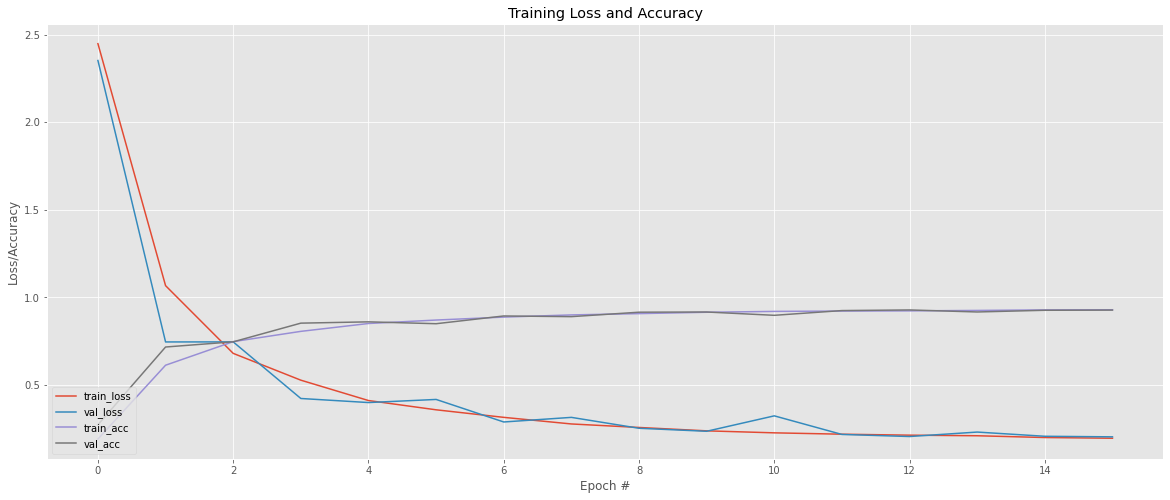

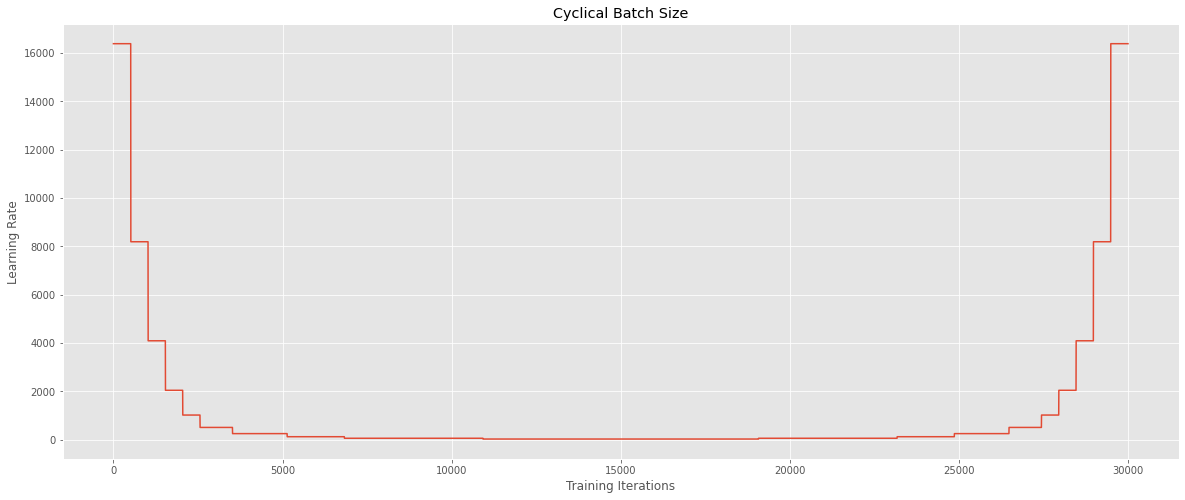

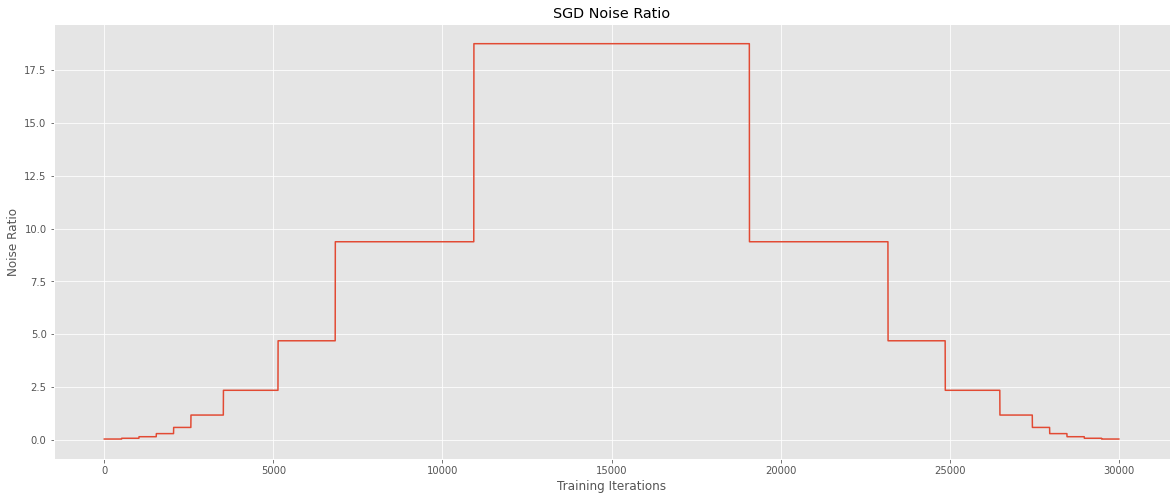

In [19]:
prefix = "BatchSizeVariationModel_"

# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(20,8))
plt.plot(N, history_object["loss"], label="train_loss")
plt.plot(N, history_object["val_loss"], label="val_loss")
plt.plot(N, history_object["accuracy"], label="train_acc")
plt.plot(N, history_object["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(prefix+"AccuracyLoss.jpg", dpi=440)
plt.show()
# plot the learning rate history
N = np.arange(0, len(batchSizeVariation))
plt.figure(figsize=(20,8))
plt.plot(N, batchSizeVariation)
plt.title("Cyclical Batch Size")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(prefix+"SizeVariations.jpg", dpi=440)
plt.show()
# plot the learning rate history
N = np.arange(0, len(noiseRatio))
plt.figure(figsize=(20,8))
plt.plot(N, noiseRatio)
plt.title("SGD Noise Ratio")
plt.xlabel("Training Iterations")
plt.ylabel("Noise Ratio")
plt.savefig(prefix+"NoiseRatio.jpg", dpi=440)
plt.show()